# Projet de classification d'image de nombre

L'objectif de ce Notebook est de présenter un exmple de classification d'images de nombre écrit à la main.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [5]:
from torch.utils.tensorboard import SummaryWriter

### Configuration Global

In [6]:
# Pour la partie Affichage
writer = SummaryWriter("runs") # indicate the path of sauvegard

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Selectionne l'appareil qui support le 

# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10 #10 nombres Existes {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
num_epochs = 2
batch_size = 50
learning_rate = 0.001

### Importe toutes les données

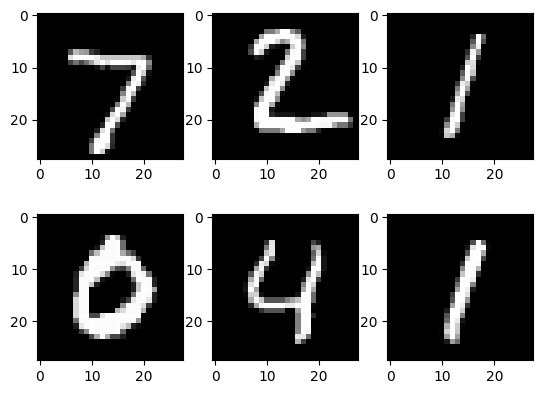

In [7]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

examples = iter(test_loader)
example_data, example_targets = next(examples)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image('mnist_images', img_grid) #Permet de rajouter un onglet sur le dash bord avec l'image ajouté
writer.close()

### Création du Neural Network

Fully connected, c'est-à-dire que tous les parametres des différentes couches succéssifs sont connectés entre eux. (Il n'y a pas de trou entre les liaisons).

Possède une Couche Cachée, c'est-à-dire une couche de parametre entre l'entré et la sortie.

In [8]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out) # Hidden Layer
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer.add_graph(model, example_data.reshape(-1, 28*28)) #Model et 1 batch of the data
writer.close()

### Entrainement du modèle

In [9]:
# Pour l'affichage
running_loss = 0.0
running_correct = 0
# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute the metrique pour l'affichage
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

            # Ajoute à l'affichage
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            writer.add_scalar('accuracy', running_correct / 100, epoch * n_total_steps + i)
            running_correct = 0
            running_loss = 0
writer.close()

Epoch [1/2], Step [100/1200], Loss: 0.3067
Epoch [1/2], Step [200/1200], Loss: 0.2587
Epoch [1/2], Step [300/1200], Loss: 0.1549
Epoch [1/2], Step [400/1200], Loss: 0.3841
Epoch [1/2], Step [500/1200], Loss: 0.3428
Epoch [1/2], Step [600/1200], Loss: 0.0888
Epoch [1/2], Step [700/1200], Loss: 0.1330
Epoch [1/2], Step [800/1200], Loss: 0.1813
Epoch [1/2], Step [900/1200], Loss: 0.2802
Epoch [1/2], Step [1000/1200], Loss: 0.3590
Epoch [1/2], Step [1100/1200], Loss: 0.0600
Epoch [1/2], Step [1200/1200], Loss: 0.2530
Epoch [2/2], Step [100/1200], Loss: 0.1264
Epoch [2/2], Step [200/1200], Loss: 0.0573
Epoch [2/2], Step [300/1200], Loss: 0.0840
Epoch [2/2], Step [400/1200], Loss: 0.1666
Epoch [2/2], Step [500/1200], Loss: 0.1342
Epoch [2/2], Step [600/1200], Loss: 0.0458
Epoch [2/2], Step [700/1200], Loss: 0.1358
Epoch [2/2], Step [800/1200], Loss: 0.0539
Epoch [2/2], Step [900/1200], Loss: 0.0722
Epoch [2/2], Step [1000/1200], Loss: 0.0605
Epoch [2/2], Step [1100/1200], Loss: 0.0280
Epoch 

### Test du modèle

In [10]:
# Affichage
tags = []
preds = []
# Test the model
# Durant la phase de teste le gradient n'a pas besoin des calculer car les poids ne sont pas réactualisés
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        class_prediction = [F.softmax(output, dim=0) for output in outputs]
        preds.append(class_prediction)
        tags.append(predicted)

    preds = torch.cat([torch.stack(batch) for batch in preds])
    tags = torch.cat(tags)

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

    classes = range(10)
    for i in classes:
        tags_i = tags == i
        preds_i = preds[:, i]
        writer.add_pr_curve(str(i), tags_i, preds_i, global_step=0)
        writer.close()


Accuracy of the network on the 10000 test images: 97.02 %


**Remaque** : 

Quelques essaient ont été réalisé avec des hyperparametres différents :
| Learning Rate (lr) | Batch Size | Accuracy |
| ------------------- | ---------- | -------- |
| 0.001               | 100        | 97.02%   |
| 0.001               | 50         | 97.45%   |
| 0.01                | 100        | 96.06%   |
| 0.01                | 50         | 95.3%    |

In [11]:
%load_ext tensorboard
%tensorboard --logdir runs --host localhost --port 8888

Launching TensorBoard...

### Sauvegarde et Enregistre un modèle

In [12]:
## Save a model - Lazy method
PATH_lazy = "save\model.pth" #extension pth **pytorch**
torch.save(model, PATH_lazy)

## Save a model - recommended method
PATH = "save\model_other_method.pth" #extension pth **pytorch**
torch.save(model.state_dict(), PATH)

In [13]:
## load model - Lazy method
model_load = torch.load(PATH_lazy)
model_load.eval()

for param in model.parameters():
    print(param)

## load model - Recommended method
loaded_model = NeuralNet(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes
    )
loaded_model.load_state_dict(
    torch.load(PATH)
    )
loaded_model.eval() 

for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0131, -0.0060,  0.0055,  ..., -0.0024,  0.0251, -0.0183],
        [ 0.0109, -0.0061, -0.0256,  ..., -0.0321,  0.0340, -0.0242],
        [ 0.0292, -0.0063,  0.0015,  ...,  0.0346,  0.0001,  0.0306],
        ...,
        [ 0.0081, -0.0195, -0.0350,  ..., -0.0326,  0.0046, -0.0304],
        [ 0.0229,  0.0340, -0.0228,  ...,  0.0275, -0.0251, -0.0161],
        [-0.0296, -0.0029, -0.0193,  ..., -0.0017, -0.0292,  0.0137]],
       requires_grad=True)
Parameter containing:
tensor([-1.4591e-02,  7.7572e-03,  1.3674e-01,  1.2107e-02,  2.1249e-03,
         1.7189e-02, -1.2886e-02,  1.0807e-01, -3.2020e-02,  9.0025e-02,
        -6.6495e-02,  8.7341e-02,  8.1548e-02,  1.1841e-01,  3.5533e-02,
         7.1772e-02,  2.5206e-02,  6.0073e-03,  2.3234e-02,  8.1166e-02,
        -3.7411e-02,  3.0906e-02, -3.2593e-02, -3.4184e-02,  1.4150e-02,
         1.2606e-01,  8.5487e-02, -2.5094e-02,  2.5176e-02,  4.8127e-02,
        -1.5499e-02, -5.6894e-02,  1.3171e-02,  7.6585e-0

In [14]:
print(model.state_dict())
# Enregistre l'état par le biais d'un dictionnaire: 

checkpoint = {
    "epoch": 90,
    "model_state": model.state_dict(),
    "optim_state": optimizer.state_dict()
}
torch.save(checkpoint, "save\checkpoint.pth")

# load
loaded_checkpoint = torch.load("save\checkpoint.pth")
epoch = loaded_checkpoint["epoch"]

model = NeuralNet(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes
    )
model.load_state_dict(checkpoint["model_state"])
optimizer.load_state_dict(checkpoint["optim_state"])

print(optimizer.state_dict())


OrderedDict([('l1.weight', tensor([[-0.0131, -0.0060,  0.0055,  ..., -0.0024,  0.0251, -0.0183],
        [ 0.0109, -0.0061, -0.0256,  ..., -0.0321,  0.0340, -0.0242],
        [ 0.0292, -0.0063,  0.0015,  ...,  0.0346,  0.0001,  0.0306],
        ...,
        [ 0.0081, -0.0195, -0.0350,  ..., -0.0326,  0.0046, -0.0304],
        [ 0.0229,  0.0340, -0.0228,  ...,  0.0275, -0.0251, -0.0161],
        [-0.0296, -0.0029, -0.0193,  ..., -0.0017, -0.0292,  0.0137]])), ('l1.bias', tensor([-1.4591e-02,  7.7572e-03,  1.3674e-01,  1.2107e-02,  2.1249e-03,
         1.7189e-02, -1.2886e-02,  1.0807e-01, -3.2020e-02,  9.0025e-02,
        -6.6495e-02,  8.7341e-02,  8.1548e-02,  1.1841e-01,  3.5533e-02,
         7.1772e-02,  2.5206e-02,  6.0073e-03,  2.3234e-02,  8.1166e-02,
        -3.7411e-02,  3.0906e-02, -3.2593e-02, -3.4184e-02,  1.4150e-02,
         1.2606e-01,  8.5487e-02, -2.5094e-02,  2.5176e-02,  4.8127e-02,
        -1.5499e-02, -5.6894e-02,  1.3171e-02,  7.6585e-02,  1.0251e-02,
         6.504

{'state': {0: {'step': tensor(2400.), 'exp_avg': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'exp_avg_sq': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}, 1: {'step': tensor(2400.), 'exp_avg': tensor([-9.3249e-05,  7.5698e-05, -4.8452e-04, -5.0895e-04,  8.7830e-05,
        -1.3093e-03, -5.5164e-05, -3.2693e-05, -3.5481e-05,  2.6537e-04,
         3.3826e-04,  9.0369e-04, -1.1897e-04,  6.1029e-04,  5.7548e-04,
         1.8348e-04,  3.7803e-04, -6.4731e-04,  1.8818e-04,  2.6265e-05,
         1.5586e-05,  4.4438e-04, -3.7537e-05,  3.2936e-04, -1.2720e-04,
        -5.5299e-05,  5

### Intégration du DashBoard et de Scheduler

In [15]:
from torch.optim import lr_scheduler 
import os

Créer un nouveau journal pour la comparaison des run en fonction du learning rate 

In [16]:
path_writer_Summary = "runs_variation_lr"

Initialisation dans un dictionnaire l'ensemble des méthodes de déterminations du learning rates

In [17]:
# Ajout d'une règle d'évolution du learning rate
dict_method_learning_rate = {}

lambda_lr_cst = lambda epoch: learning_rate
lmb_schedular_cst = lambda optimizer: lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr_cst)
dict_method_learning_rate['cst'] = lmb_schedular_cst
lambda_lr_puissance = lambda epoch: 0.9 ** epoch
lmb_schedular_lambda = lambda optimizer: lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr_puissance)
dict_method_learning_rate['lambda'] = lmb_schedular_lambda
lmb_schedular_Mult = lambda optimizer: lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda coeff_mul: 0.95)
dict_method_learning_rate['Mult'] = lmb_schedular_Mult
lmb_schedular_Step = lambda optimizer: lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
dict_method_learning_rate['Step'] = lmb_schedular_Step
lmb_schedular_Exp = lambda optimizer: lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
dict_method_learning_rate['Exp'] = lmb_schedular_Exp
lmb_schedular_OneCycle = lambda optimizer: lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=2)
dict_method_learning_rate['OneCycle'] = lmb_schedular_OneCycle

In [22]:
# Pour l'affichage
running_loss = 0.0
running_correct = 0

# dict of model after training
dict_model = {}

# Train the model
n_total_steps = len(train_loader)
for name_lr_model, lmb_lr_model in dict_method_learning_rate.items():
    print(f"start: {name_lr_model}")
    dict_model[name_lr_model] = {}
    model = NeuralNet(input_size, hidden_size, num_classes).to(device)
    # Loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    writer = SummaryWriter(os.path.join(path_writer_Summary, name_lr_model))
    schedular = lmb_lr_model(optimizer)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # origin shape: [100, 1, 28, 28]
            # resized: [100, 784]
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            schedular.step()

            # Compute the metrique pour l'affichage
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels).sum().item()
            
            if (i+1) % 100 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

                # Ajoute à l'affichage
                writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
                writer.add_scalar('accuracy', running_correct / 100, epoch * n_total_steps + i)
                writer.add_scalar("learning rate", schedular.get_last_lr()[0], epoch * n_total_steps + i)

                running_correct = 0
                running_loss = 0
    writer.close()
    dict_model[name_lr_model]['model'] = model
    dict_model[name_lr_model]['writer'] = writer


start: cst
Epoch [1/2], Step [100/1200], Loss: 2.3213
Epoch [1/2], Step [200/1200], Loss: 2.3040
Epoch [1/2], Step [300/1200], Loss: 2.3036
Epoch [1/2], Step [400/1200], Loss: 2.3031
Epoch [1/2], Step [500/1200], Loss: 2.2801
Epoch [1/2], Step [600/1200], Loss: 2.2563
Epoch [1/2], Step [700/1200], Loss: 2.2473
Epoch [1/2], Step [800/1200], Loss: 2.2476
Epoch [1/2], Step [900/1200], Loss: 2.2361
Epoch [1/2], Step [1000/1200], Loss: 2.2327
Epoch [1/2], Step [1100/1200], Loss: 2.2030
Epoch [1/2], Step [1200/1200], Loss: 2.2122
Epoch [2/2], Step [100/1200], Loss: 2.2221
Epoch [2/2], Step [200/1200], Loss: 2.1758
Epoch [2/2], Step [300/1200], Loss: 2.2018
Epoch [2/2], Step [400/1200], Loss: 2.1534
Epoch [2/2], Step [500/1200], Loss: 2.1810
Epoch [2/2], Step [600/1200], Loss: 2.1425
Epoch [2/2], Step [700/1200], Loss: 2.1435
Epoch [2/2], Step [800/1200], Loss: 2.1661
Epoch [2/2], Step [900/1200], Loss: 2.1696
Epoch [2/2], Step [1000/1200], Loss: 2.1112
Epoch [2/2], Step [1100/1200], Loss: 2.

Phase d'entrainement pour l'ensemble des jeu de données avec des learning rates différents

In [23]:
for model_with_method_lr_specific, dict_model in dict_model.items():
    model = dict_model['model']
    writer = dict_model['writer']
    # Affichage
    tags = []
    preds = []
    # Test the model
    # Durant la phase de teste le gradient n'a pas besoin des calculer car les poids ne sont pas réactualisés
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            class_prediction = [F.softmax(output, dim=0) for output in outputs]
            preds.append(class_prediction)
            tags.append(predicted)

        preds = torch.cat([torch.stack(batch) for batch in preds])
        tags = torch.cat(tags)

        acc = 100.0 * n_correct / n_samples
        print(
            'Accuracy of the network with the learning rate methode :' +\
            f'{model_with_method_lr_specific} on the 10000 test images: {acc} %'
            )

        classes = range(10)
        for i in classes:
            tags_i = tags == i
            preds_i = preds[:, i]
            writer.add_pr_curve(str(i), tags_i, preds_i, global_step=0)
            writer.close()

Accuracy of the network with the learning rate methode :cst on the 10000 test images: 65.11 %
Accuracy of the network with the learning rate methode :lambda on the 10000 test images: 72.99 %
Accuracy of the network with the learning rate methode :Mult on the 10000 test images: 83.0 %
Accuracy of the network with the learning rate methode :Step on the 10000 test images: 29.32 %
Accuracy of the network with the learning rate methode :Exp on the 10000 test images: 19.21 %
Accuracy of the network with the learning rate methode :OneCycle on the 10000 test images: 87.07 %


Si vous êtres sur Vs Code 
- Crtl + shift + P 
- rechercher la commande  Python: Launch Tensorboard
- Choissiser le dossier contenant les différentes informations

In [24]:
%load_ext tensorboard
%tensorboard --logdir runs_variation_lr --host localhost --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 23732), started 0:12:09 ago. (Use '!kill 23732' to kill it.)

In [25]:
1903632 / 1938986 - 1

-0.01823324149839145